# Scenario Builder

In [1]:
using Pkg;
Pkg.activate("..")

  Activating project at `~/Documents/repos/GatekeeperFormationFlight.jl/examples`


In [2]:
using Revise
using GatekeeperFormationFlight

In [94]:
using StaticArrays
using YAML
using Plots
using Polynomials
using Dubins3D
using Random

In [4]:
include("./file_util.jl")
include("../3d_example_utils.jl")
include("./demo_util_types.jl")
include("./demo_util.jl")

Main.DemoUtil

## Create the Scenario

### Create the Obstacles

In [ ]:
# Empty Vector of Obstacles
obstacles = Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}()

In [ ]:
gate_1 = Cylinder(0.0, 0.0, 0.35)
push!(obstacles, obs_1)

# obs_2 = Sphere(2.5, 1.5, 1.5, 0.5)
# push!(obstacles, obs_2)

In [ ]:
obstacles_dict = [FileUtil.obstacle_to_dict(obs) for obs in obstacles]

### Create the Gatekeeper Coefficients Object

In [ ]:
# Create desired object using kwarg constructor
coeffs = GatekeeperCoefficients(
    switch_step_size = 0.25,
    reconnection_step_size = 0.125,
    max_Ts_horizon = 10.0,
    integration_max_step_size = 0.05,
    integration_step_size = 0.01,
    collision_check_step_size = 0.05
)

# Convert to dictionary with symbol keys
coeffs_dict = Dict(fieldnames(GatekeeperCoefficients) .=> getfield.(Ref(coeffs), fieldnames(GatekeeperCoefficients)))

### Create the Agent Settings

In [ ]:
agent_settings = DemoUtil.AgentSettings(
    v_min = 0.8,
    v_max = 1.0,
    x_padding = 0.1,
    agent_radius = 0.15,
    turn_radius = 1.,
    pitch_limits = SVector(-pi / 4, pi / 4)
)

agent_settings_dict = Dict(fieldnames(DemoUtil.AgentSettings) .=> getfield.(Ref(agent_settings), fieldnames(DemoUtil.AgentSettings)))

### Set Agent Offsets

In [ ]:
sim_agents = Vector{DemoUtil.SimAgent}()

In [ ]:
agent1 = DemoUtil.SimAgent(
    id = 1,
    offset = SVector(0.0, 0.0, 0.0, 0.0, 0.0)
)
agent2 = DemoUtil.SimAgent(
    id = 2,
    offset = SVector(-0.3, -0.6, 0.0, 0.0, 0.0)
)
agent3 = DemoUtil.SimAgent(
    id = 3,
    offset = SVector(-0.3, 0.6, 0.0, 0.0, 0.0)
)

push!(sim_agents, agent1)
push!(sim_agents, agent2)
push!(sim_agents, agent3)

In [ ]:
sim_agents_out = [Dict(fieldnames(DemoUtil.SimAgent) .=> getfield.(Ref(sim_agent), fieldnames(DemoUtil.SimAgent))) for sim_agent in sim_agents]

### Create the Scenario

In [ ]:
scenario = DemoUtil.SimScenario(
    name = "gate_scenario_1",
    start_pose = SVector(-1.8, -1.2, 0.5, 0.0, 0.0),
    goal_pose = SVector(1.8, 1.2, 1.5, 0.0, 0.0),
    domain_min = SVector(-3.0, -2.0, 0.0), 
    domain_max = SVector(2.0, 2.0, 2.0)
)
scenario_dict = Dict(fieldnames(DemoUtil.SimScenario) .=> getfield.(Ref(scenario), fieldnames(DemoUtil.SimScenario)))

### Write YAML

In [ ]:
output_object = Dict(
    "gatekeeper_coefficients" => coeffs_dict,
    "obstacles" => obstacles_dict,
    "agent_settings" => agent_settings_dict,
    "agents" => sim_agents_out,
    "scenario" => scenario_dict
)

YAML.write_file("scenarios/$(scenario_dict[:name]).yaml", output_object)


### Plot the Scenario

In [ ]:
## 2D plot showing the scenario domain, and start & goal poses w/offsets

# Extract domain and poses
domain_min = scenario.domain_min
domain_max = scenario.domain_max
start_pose = scenario.start_pose
goal_pose = scenario.goal_pose

# Agent offsets
offsets = [agent.offset for agent in sim_agents]

# Plot domain as rectangle
p = plot(; legend=false, aspect_ratio=:equal, title="Scenario Domain and Agent Poses")
plot!(p, [domain_min[1], domain_max[1], domain_max[1], domain_min[1], domain_min[1]],
         [domain_min[2], domain_min[2], domain_max[2], domain_max[2], domain_min[2]],
         seriestype=:shape, fillalpha=0.1, color=:gray, label="Domain")

# Plot start and goal poses
scatter!(p, [start_pose[1]], [start_pose[2]], color=:green, marker=:star5, markersize=8, label="Start")
scatter!(p, [goal_pose[1]], [goal_pose[2]], color=:red, marker=:star5, markersize=8, label="Goal")

# Plot agent offsets at start
for (i, offset) in enumerate(offsets)
    scatter!(p, [start_pose[1] + offset[1]], [start_pose[2] + offset[2]],
             color=:blue, marker=:circle, markersize=6, label="Agent $i Start Offset")
end

# Plot agent offsets at goal
for (i, offset) in enumerate(offsets)
    scatter!(p, [goal_pose[1] + offset[1]], [goal_pose[2] + offset[2]],
             color=:orange, marker=:circle, markersize=6, label="Agent $i Goal Offset")
end

for obs in env.obstacles
    plot!(p, PlotCircle(obs), label = false, linedwidth = 2)
end

display(p)


## Load YAML

In [ ]:
obj = YAML.load_file("scenarios/demo_scenario.yaml"; dicttype=Dict{Symbol, Any})

In [ ]:
coeffs_in = obj[:gatekeeper_coefficients]
gk_coeffs = GatekeeperCoefficients(; coeffs_in...)
obj[:gatekeeper_coefficients] = gk_coeffs

In [ ]:
objects_in = obj[:obstacles]
objects = [FileUtil.dict_to_obstacle(obs) for obs in objects_in]
obj[:obstacles] = objects

In [ ]:
obj[:agent_settings] = DemoUtil.AgentSettings(; obj[:agent_settings]...)

In [ ]:
obj[:agents] = [DemoUtil.SimAgent(; agent...) for agent in obj[:agents]]

In [ ]:
# @show obj[:scenario]
obj[:scenario] = DemoUtil.SimScenario(; obj[:scenario]...)

In [ ]:
# sim_env = DemoUtil.SimEnvironment(; obj...)
sim_env = DemoUtil.SimEnvironment(; obj...)

## Testing with DemoUtil

In [288]:
# include("../3d_example_utils.jl")
include("./demo_util.jl")

Main.DemoUtil

In [289]:
# env = DemoUtil.load_env("scenarios/test_scenario_1.yaml")

env = DemoUtil.load_env("scenarios/gate_scenario_2.yaml")

SimEnvironment(SimScenario("gate_scenario_2", 20.0, 0.005, [-2.5, -0.75, 1.5, 0.0, 0.0], [2.0, 2.0, 1.5, 0.0, 0.0], [-3.0, -2.0, 0.0], [2.5, 2.0, 3.0]), AgentSettings(0.7, 1.0, 0.2, 0.0, 0.2, 0.5, [-0.7853981633974483, 0.7853981633974483]), SimAgent[SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), SimAgent(2, [-0.5, -0.3, 0.0, 0.0, 0.0]), SimAgent(3, [-0.5, 0.3, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[FPVGate{Float64}([0.25, 0.25, 2.15]), Cylinder{Float64}([-1.7, 0.3, 0.0], 0.55)], GatekeeperCoefficients{Float64}(10.0, 0.05, 0.01, 0.02, 0.005, 0.05), nothing, nothing, nothing, nothing, nothing)

In [ ]:
Random.seed!(12360)
success = DemoUtil.solve_leader_path!(env)

true

### Plot the Solved Path

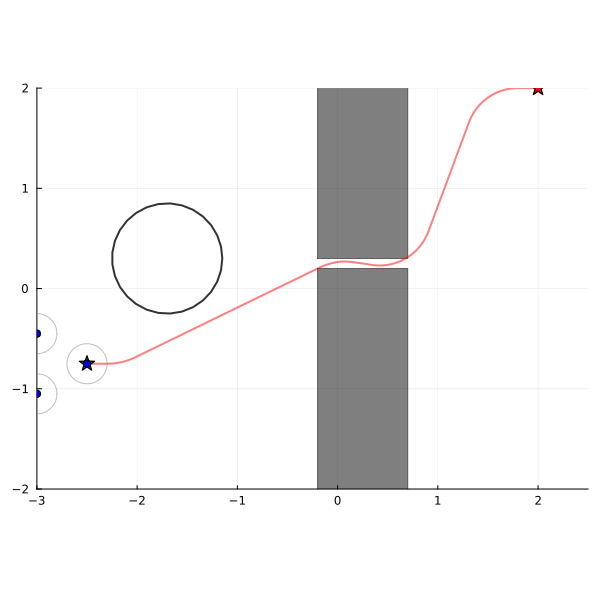

In [307]:
p = ExampleUtils3D.visualize_baseline_2d(env.obstacles, env.leader_path; dims_min=env.scenario.domain_min[1:2], dims_max=env.scenario.domain_max[1:2])

# p = plot()
# for obs in env.obstacles
#     plot!(p, get_2d_repr(obs), label=false)
# end

xlims!(p, env.scenario.domain_min[1], env.scenario.domain_max[1])
ylims!(p, env.scenario.domain_min[2], env.scenario.domain_max[2])

plot!(p, [env.scenario.start_pose[1]], [env.scenario.start_pose[2]], marker=:star5, markersize=8, color=:green, label="Start")
plot!(p, [env.scenario.goal_pose[1]], [env.scenario.goal_pose[2]], marker=:star5, markersize=8, color=:red, label="Goal")

# Add plots for the offset agents. The offset should take into account orientation of the start pose
# additionally, plot the inter-agent collision radius as a circle around each agent
for (i, agent) in enumerate(env.agents)
    offset = agent.offset
    # Compute rotated offset using start pose yaw (4th element)
    θ = env.scenario.start_pose[4]
    R = [cos(θ) -sin(θ); sin(θ) cos(θ)]
    offset_xy = R * offset[1:2]
    agent_x = env.scenario.start_pose[1] + offset_xy[1]
    agent_y = env.scenario.start_pose[2] + offset_xy[2]
    scatter!(
        p,
        [agent_x],
        [agent_y],
        marker=:circle,
        color=:blue,
        label="Agent $i Start Offset"
    )
    # Plot collision radius as a circle
    r = env.agent_settings.agent_radius
    θs = range(0, 2π, length=100)
    circle_x = agent_x .+ r .* cos.(θs)
    circle_y = agent_y .+ r .* sin.(θs)
    plot!(p, circle_x, circle_y, color=:gray, alpha=0.5, label=false)
end

display(p)


### Solve the GK Problem & Plot

In [311]:
# include("./demo_util.jl")
Random.seed!(123141)
success = DemoUtil.solve_gk_problem!(env)

true

In [309]:
# settings = env.agent_settings
# new_settings = DemoUtil.AgentSettings(
#     v_max = settings.v_max,
#     x_padding = settings.x_padding,
#     y_padding = settings.y_padding,  # Added y_padding
#     agent_radius = settings.agent_radius,
#     turn_radius = 0.15,
#     pitch_limits = settings.pitch_limits
# )
# env.agent_settings = new_settings

# @show env.agent_settings.turn_radius

### Plot the Interagent Solution

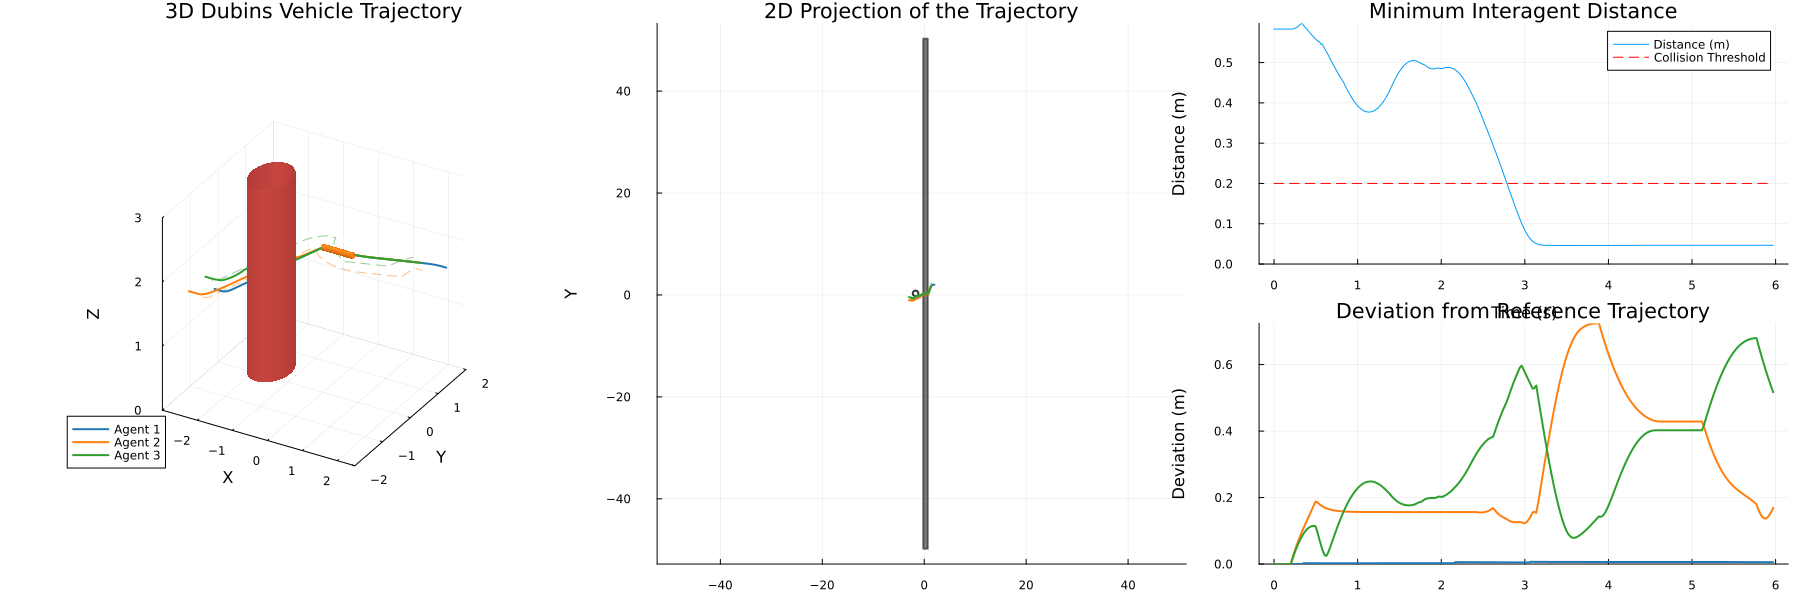

In [312]:
p1 = ExampleUtils3D.plot_interagent_solution(env.solution, env.gk; dims_min=env.scenario.domain_min, dims_max=env.scenario.domain_max)

In [300]:
@show env.solution[1]
@show env.leader_path[1]

DubinsManeuver3D{Float64}([-2.4, 0.0, 0.5, 1.570795, 0.0], [-2.4, 0.2, 0.5, 1.570795, 0.0], 0.25, [-0.7853981633974483, 0.7853981633974483], DubinsManeuver2D[DubinsManeuver2D{Float64}([-2.4, 0.0, 1.570795], [-2.4, 0.2, 1.570795], 0.49753500012, Dubins3D.DubinsStruct{Float64}(1.326799275137139e-6, 0.40197911643121975, 1.326799275137139e-6, 0.19999999999999943, "LSR")), DubinsManeuver2D{Float64}([0.0, 0.5, 0.0], [0.19999999999999943, 0.5, 0.0], 0.2891542454840756, Dubins3D.DubinsStruct{Float64}(0.0, 0.6916723621511339, 0.0, 0.1999999999999994, "LSL"))], 0.19999999999999937)

### Animate 2D View of Solution

Plots.AnimatedGif("/Users/marshallvielmetti/Documents/repos/GatekeeperFormationFlight.jl/examples/caams_demo/interagent_2d_animation_demo.gif")
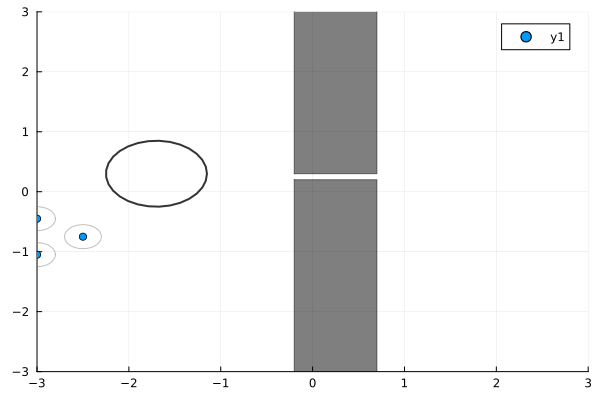

In [305]:
# include("../3d_example_utils.jl")
anim = ExampleUtils3D.animate_interagent_2d(env.solution, env.gk)
gif(anim, "interagent_2d_animation_demo.gif", fps=10)

### Write Solution to File

In [284]:
DemoUtil.write_to_file(env, "scenarios/demo_scenario_solution.csv", env.scenario.reconstruction_step_size)

3642×6 DataFrame
  Row │ pos_z    time         pos_y     heading      agent_id  pos_x    
      │ Float64  Float64      Float64   Float64      Int64     Float64  
──────┼─────────────────────────────────────────────────────────────────
    1 │ 1.5      0.0          -0.75      0.0                1  -2.5
    2 │ 1.5      0.0          -1.05      0.0                2  -3.0
    3 │ 1.5      0.0          -0.45      0.0                3  -3.0
    4 │ 1.5      0.000824052  -0.75      0.0                1  -2.495
    5 │ 1.5      0.000824052  -1.05      0.0                2  -2.995
    6 │ 1.5      0.000824052  -0.45      0.0                3  -2.995
    7 │ 1.5      0.0016481    -0.75      0.0                1  -2.49
    8 │ 1.5      0.0016481    -1.05      0.0                2  -2.99
  ⋮   │    ⋮          ⋮          ⋮           ⋮          ⋮         ⋮
 3636 │ 1.54482  0.997926      1.84225   0.813615           3   1.11959
 3637 │ 1.5      0.99875       2.0      -5.03157e-5         1   1.99051
 3638 │ 1.54995  0.99875       1.55475   1.07925            2   1.39092
 3639 │ 1.54463  0.99875       1.84589   0.814961           3   1.12302
 3640 │ 1.5      0.999575      2.0      -4.17548e-5         1   1.99551
 3641 │ 1.5497   0.999575      1.55914   1.06925            2   1.3933
 3642 │ 1.54444  0.999575      1.84953   0.809776           3   1.12646
                                                       3627 rows omitted

In [285]:
chunk_polys = DemoUtil.fit_polynomials(env.data, chunk_size=80; trajectory_time=20.0) # TODO

48-element Vector{Any}:
 (agent_id = 1.0, duration = 1.3184825047734872, var"x^0" = -2.499701159315661, var"x^1" = 0.2990554317728323, var"x^2" = 0.01224019190715965, var"x^3" = -0.009079961360551553, var"x^4" = 0.0, var"x^5" = 0.0, var"x^6" = 0.0, var"x^7" = 0.0, var"y^0" = -0.7505510613980992, var"y^1" = 0.011268066407873905, var"y^2" = -0.04247820637983122, var"y^3" = 0.04056272145778866, var"y^4" = 0.0, var"y^5" = 0.0, var"y^6" = 0.0, var"y^7" = 0.0, var"z^0" = 1.499606369817629, var"z^1" = 0.0078056338853978715, var"z^2" = -0.028882811624473433, var"z^3" = 0.027239099984831303, var"z^4" = 0.0, var"z^5" = 0.0, var"z^6" = 0.0, var"z^7" = 0.0, var"yaw^0" = 0.0196011530129585, var"yaw^1" = -0.2190376119644405, var"yaw^2" = 0.3635528765254873, var"yaw^3" = -0.004557880055477039, var"yaw^4" = 0.0, var"yaw^5" = 0.0, var"yaw^6" = 0.0, var"yaw^7" = 0.0)
 (agent_id = 1.0, duration = 1.3184825047734872, var"x^0" = -2.1053141090312533, var"x^1" = 0.2619408699216516, var"x^2" = -0.004250635123

### Plot the Chunk Polynomials

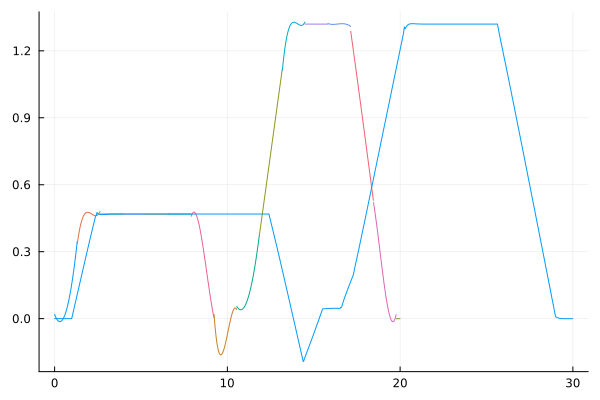

In [286]:
p = plot(legend = false)
start_time = 0.0
for pnom in chunk_polys
    if values(pnom)[1] != 1.0
        continue
    end
    # reconstruct polynomial from coefficients
    px = Polynomial(values(pnom)[3:10])
    py = Polynomial(values(pnom)[11:18])
    pz = Polynomial(values(pnom)[19:26])
    pyaw = Polynomial(values(pnom)[27:34])

    plot!(
        p,
        τ -> τ,
        # τ -> px(τ),
        # τ -> py(τ),
        τ -> pyaw(τ-start_time),
        start_time:0.01:(start_time + pnom.duration),
    )

    start_time += pnom.duration
end

temp_data = env.data[env.data.agent_id .== 1, :]

plot!(p,
    temp_data.time*30,
    temp_data.heading,
)

zlims!(p, 0.0, 2.0)

display(p)

### Write the Polynomials to a File

In [287]:
DemoUtil.write_polynomials_to_file(chunk_polys, "scenarios/$(env.scenario.name)_trajectories.csv")

"scenarios/gate_scenario_2_trajectories.csv"

## Testing w/FPV Gate

In [ ]:
using Revise
using GatekeeperFormationFlight

In [ ]:
obstacles = Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}()
obs_1 = FPVGate(SVector(0.0, 0.0, 0.5))
push!(obstacles, obs_1)

In [ ]:
p = plot(obs_1, label = "FPV Gate", linewidth = 2, color = :blue)
xlims!(p, -5.0, 5.0)
ylims!(p, -5.0, 5.0)
zlims!(p, 0.0, 5.0)

In [ ]:
# Set up grid in x and y
nx, ny = 100, 100
xgrid = range(-2, 2, length=nx)
ygrid = range(-2, 2, length=ny)

# Use the FPVGate's z coordinate for all points
zval = obs_1.pos[3]  # or use your FPVGate object, e.g. obs_1

# Compute collision distance for each (x, y)
cdist = [collision_distance(obs_1, SVector(x, y, zval), 0.0) for y in ygrid, x in xgrid]
cdist_masked = [v < 0 ? -1.0 : v for v in cdist]

# Plot as heatmap
# heatmap(xgrid, ygrid, cdist, xlabel="x", ylabel="y", title="FPVGate Collision Distance Heatmap")
heatmap(
    xgrid, ygrid, cdist_masked,
    xlabel="x", ylabel="y", title="FPVGate Collision Distance Heatmap",
    color = cgrad([:red, :white, :blue], [0.0, 0.01, 1.0]), # red for collision, blue/white for safe
    clims = (-1, maximum(cdist_masked))
)

In [ ]:
p = plot(label = "FPV Gates 2D")
xlims!(p, -5.0, 5.0)
ylims!(p, -5.0, 5.0)

gate_1 = FPVGate(SVector(-2.5, 2.0, 0.35))
gate_2 = FPVGate(SVector(0.0, -2.0, 0.35))
gate_3 = FPVGate(SVector(2.5, 0.0, 0.35))
plot!(get_2d_repr(gate_1))
plot!(get_2d_repr(gate_2))
plot!(get_2d_repr(gate_3))

# p3d = plot(camera = (9000, 0))
p3d = plot()
xlabel!(p3d, "x")
ylabel!(p3d, "y")
zlabel!(p3d, "z")
p3d = plot!(gate_1, label = "FPV Gate 1", linewidth = 2, color = :blue)
p3d = plot!(gate_2, label = "FPV Gate 2", linewidth = 2, color = :blue)
p3d = plot!(gate_3, label = "FPV Gate 3", linewidth = 2, color = :blue)
xlims!(p3d, -3.0, 3.0)
ylims!(p3d, -3.0, 3.0)
zlims!(p3d, 0.0, 3.0)

comb = plot(p3d, p, layout = (1, 2), size = (800, 400), title = "FPV Gates 2D and 3D")

display(comb)

## Debugging RRT W/ Gates

In [99]:
domain_min = SVector{5,Float64}(
    env.scenario.domain_min[1],
    env.scenario.domain_min[2],
    env.scenario.domain_min[3],
    -π,
    env.agent_settings.pitch_limits[1],
)
domain_max = SVector{5,Float64}(
    env.scenario.domain_max[1],
    env.scenario.domain_max[2],
    env.scenario.domain_max[3],
    π,
    env.agent_settings.pitch_limits[2],
)

rrt_domain = (domain_min, domain_max)

# Construct the rrt problem instance
rrt_problem =
    Dubins3DRRTProblem(rrt_domain, env.agent_settings.turn_radius, env.obstacles)

# Padding on the start and end states -- pre-apply the x-padding
x0 = @SVector [
    env.scenario.start_pose[1] + env.agent_settings.x_padding,
    env.scenario.start_pose[2],
    env.scenario.start_pose[3],
    env.scenario.start_pose[4],
    env.scenario.start_pose[5],
]

xg = @SVector [
    env.scenario.goal_pose[1] - env.agent_settings.x_padding,
    env.scenario.goal_pose[2],
    env.scenario.goal_pose[3],
    env.scenario.goal_pose[4],
    env.scenario.goal_pose[5],
]

nodes = [Node(x0)]
nodes = rrt_star(rrt_problem, nodes, 500)


750-element Vector{Node{SVector{5, Float64}}}:
 Node{SVector{5, Float64}}([-2.8, 1.5, 1.5, 0.0, 0.0], 0, 0.0)
 Node{SVector{5, Float64}}([-2.948647352807696, 0.25127501450807155, 2.3801925802247106, -2.2587457935296893, 0.6379107305581164], 1, 1.7513008955236693)
 Node{SVector{5, Float64}}([-0.138823149929721, 1.5567078640972072, 1.1477208550092721, 0.29034363763658333, 0.519568184287696], 1, 2.7001522377693083)
 Node{SVector{5, Float64}}([-3.485858610863526, -0.08352821429590307, 0.1513253964850394, 2.3692033568520654, 0.6867880011709637], 1, 2.869633664284804)
 Node{SVector{5, Float64}}([-1.6771465084536235, -1.2260764890373417, 2.0898825907345486, -2.1501946702707473, -0.5476872457365476], 1, 3.1574842304480484)
 Node{SVector{5, Float64}}([-1.8013187914630417, -0.24026646860354323, 2.300815945332281, 0.1463903959555051, -0.4717537314443006], 1, 2.3747446824263982)
 Node{SVector{5, Float64}}([-0.9138962985267716, -0.21953836282965788, 0.31919396441491354, 0.4325247689234626, 0.041494

### Plot all the sampled nodes in 2D, with the gate

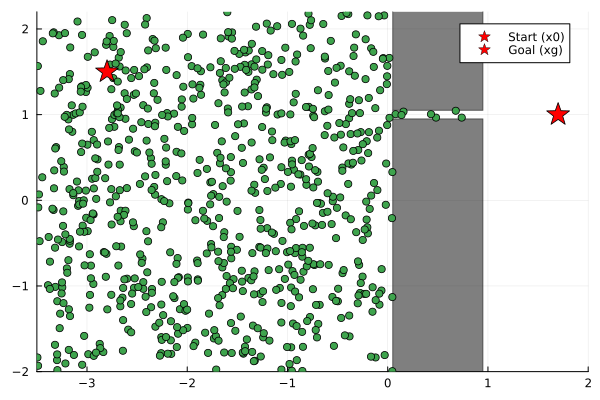

In [101]:
p = plot()

for obs in env.obstacles
    plot!(get_2d_repr(obs), label = false)
    # plot!(obs, label = false, linewidth = 2)
end

# Plot the RRT nodes in 2D
xs = [node.state[1] for node in nodes]
ys = [node.state[2] for node in nodes]
# zs = [node.state[3] for node in nodes]

scatter!(xs, ys, label=false)

xlims!(p, env.scenario.domain_min[1], env.scenario.domain_max[1])
ylims!(p, env.scenario.domain_min[2], env.scenario.domain_max[2])
zlims!(p, env.scenario.domain_min[3], env.scenario.domain_max[3])


# plot the start and goal poses as stars
scatter!(p, [x0[1]], [x0[2]], color=:red, marker=:star5, markersize=12, label="Start (x0)")
scatter!(p, [xg[1]], [xg[2]], color=:red, marker=:star5, markersize=12, label="Goal (xg)")

display(p)

In [ ]:
success, waypoints = get_best_path(rrt_problem, nodes, xg)

## Is Colliding Duration Addition
Fails to plan an initial committed trajectory? Like are we so fr

In [8]:
GFF = GatekeeperFormationFlight

GatekeeperFormationFlight

### Prep Environment

In [37]:
sort!(env.agents, by = x -> x.id)
offsets = [SVector{3,Float64}(agent.offset[1:3]...) for agent in env.agents]

gk = GKDubinsObs3DInterAgent(;
    static_obstacles = env.obstacles,
    reference_path = env.leader_path,
    offset = offsets,
    turning_radius = env.agent_settings.turn_radius,
    pitch_limits = env.agent_settings.pitch_limits,
    v_min = env.agent_settings.v_min,
    v_max = env.agent_settings.v_max,
    agent_radius = env.agent_settings.agent_radius,
)

mgk_instance = GatekeeperInstance(
    gk, env.gatekeeper_coefficients
)

candidate = GFF.CompositeTrajectory(
    Vector{Any}(),
    Vector{Any}(),
    Vector{Float64}(),
)

rotation_matrix = @SMatrix [
    [cos(env.scenario.start_pose[4]) -sin(env.scenario.start_pose[4]) 0.0]
    [sin(env.scenario.start_pose[4]) cos(env.scenario.start_pose[4]) 0.0]
    [0.0 0.0 1.0]
]
initial_positions = [
    env.scenario.start_pose +
    SVector{5,Float64}((rotation_matrix * offset)..., 0.0, 0.0) for
    offset in offsets
]

initial_positions = reduce(hcat, initial_positions)'
tspan = [0.0, sum(x -> x.length, env.leader_path)]

2-element Vector{Float64}:
 0.0
 9.63489756285085

#### Agent 1

In [38]:

push!(candidate.nominal, nothing)
push!(candidate.backup, nothing)
push!(candidate.switch_time, 0.0)

success = GFF.MultiGatekeeper.try_update_agent_committed!(
    candidate,
    mgk_instance,
    initial_positions,
    1,
    0.0
)

true

#### Agent 2

In [39]:
push!(candidate.nominal, nothing)
push!(candidate.backup, nothing)
push!(candidate.switch_time, 0.0)

agent_gk = GFF.GatekeeperInstance(
    GFF.MultiGatekeeper.get_single_agent_subproblem(mgk_instance.problem, 2, candidate),
    env.gatekeeper_coefficients
)


GatekeeperInstance{GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}}(GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}(GatekeeperFormationFlight.Obstacles.AbstractObstacle[FPVGate{Float64}([-1.5, 1.8, 0.35]), FPVGate{Float64}([0.6, -0.6, 0.95]), TimeVaryingSphere{Float64}(GatekeeperFormationFlight.var"#position_function#58"{Float64, SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, GatekeeperInstance{GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{Functi

In [36]:
@show length(candidate.switch_time)

length(candidate.switch_time) = 4


4

In [ ]:
EXCLUSION_RADIUS = env.agent_settings.agent_radius
function make_pos_function(nom, bak, t_switch)
    function position_function(t::Float64)::SVector{3, Float64}
        if t < t_switch
            return SVector{3, Float64}(nom(t)[1:3])
        else
            return SVector{3, Float64}(
                Dubins3DTrackingController.get_reference_state_and_input(
                    bak,
                    t - t_switch,
                )[1][1:3]
            )
        end
    end
end

pos_func_1 = make_pos_function(
    candidate.nominal[1],
    candidate.backup[1],
    candidate.switch_time[1]
)

(::var"#position_function#25"{SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, GatekeeperInstance{GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, GatekeeperInstance{GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Gat

#### Plot the Make Pos Function Result

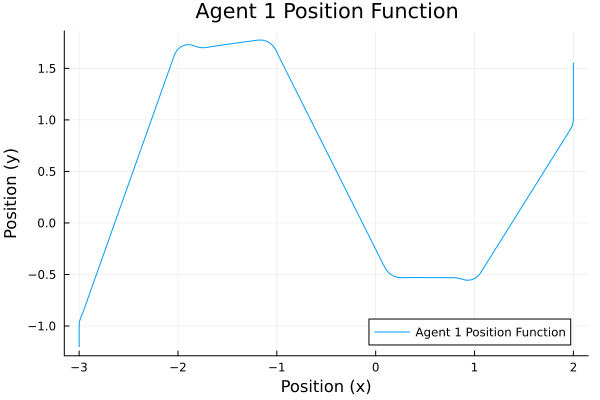

In [27]:
plot(τ -> pos_func_1(τ)[1], τ -> pos_func_1(τ)[2], 0.0, 10.0, label="Agent 1 Position Function",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

In [40]:
agent_2_gk = GFF.GatekeeperInstance(
    GFF.get_single_agent_subproblem(mgk_instance.problem, 2, candidate),
    env.gatekeeper_coefficients
)

GatekeeperInstance{GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}}(GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}(GatekeeperFormationFlight.Obstacles.AbstractObstacle[FPVGate{Float64}([-1.5, 1.8, 0.35]), FPVGate{Float64}([0.6, -0.6, 0.95]), TimeVaryingSphere{Float64}(GatekeeperFormationFlight.var"#position_function#58"{Float64, SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, GatekeeperInstance{GKDubinsObs3D{Vector{GatekeeperFormationFlight.Obstacles.AbstractObstacle}, Vector{Dubins3D.DubinsManeuver3D}, SVector{3, Float64}, Float64}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{Functi

In [41]:
agent_2_nominal = GFF.Gatekeeper.construct_candidate_nominal_trajectory(
    agent_2_gk,
    initial_positions[2, :],
    0.0,
)

retcode: Terminated
Interpolation: specialized 4th order "free" interpolation
t: 144-element Vector{Float64}:
 0.0
 0.005
 0.01799023888055074
 0.03799023888055074
 0.05799023888055074
 0.07799023888055075
 0.09799023888055075
 0.11799023888055075
 0.13799023888055076
 0.15799023888055075
 ⋮
 2.6247621567560944
 2.6447621567560944
 2.6647621567560944
 2.6847621567560944
 2.7047621567560944
 2.7247621567560945
 2.7447621567560945
 2.7537386804282624
 2.7537386804282624
u: 144-element Vector{Vector{Float64}}:
 [-2.650000530718267, -1.6000004643778618, 0.5, 1.570795, 0.0]
 [-2.650000522581091, -1.5950004643774363, 0.5, 1.570793632991552, 0.0]
 [-2.6500004621226405, -1.5820102254970325, 0.5, 1.5707902123786293, 0.0]
 [-2.650000323869846, -1.5620102254975106, 0.5, 1.570789234337606, 0.0]
 [-2.6500001937676223, -1.542010225497935, 0.5, 1.5707906098663498, 0.0]
 [-2.650000098496213, -1.5220102254981651, 0.5, 1.5707925146657138, 0.0]
 [-2.650000039348534, -1.5020102254982548, 0.5, 1.5707941481

#### Plot Agent 2's Nominal

In [ ]:
p = plot()
plot(τ -> pos_func_1(τ)[1], τ -> pos_func_1(τ)[2], 0.0, 10.0, label="Agent 1 Position Function",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

plot(τ -> agent_2_nominal(τ)[1], τ -> pos_func_1(τ)[2], 0.0, 10.0, label="Agent 2 Nominal",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

agent_2_nominal.t[end] = 2.7537386804282624


2.7537386804282624

In [43]:
mas_check_until_time = max([st for st in candidate.switch_time]...)

6.901102278260621

In [44]:
nominal_2_end_time = agent_2_nominal.t[end]

2.7537386804282624

In [86]:
switch_2_time = nominal_2_end_time - 0.15
agent_2_backup = GFF.Gatekeeper.construct_candidate_backup_trajectory(
    agent_2_gk,
    agent_2_nominal(switch_2_time),
    switch_2_time,
    mas_check_until_time
)

In [87]:
reconnection_sites = GFF.Gatekeeper.construct_reconnection_sites(
    agent_2_gk.problem,
    env.gatekeeper_coefficients.reconnection_step_size
)

195-element Vector{Tuple{Int64, SVector{5, Float64}}}:
 (1, [-3.0, -1.2, 0.5, 1.570795, 0.0])
 (1, [-2.99999999999987, -1.15, 0.5, 1.570796326797497, 0.0])
 (1, [-3.0, -1.0999999999999999, 0.5, 1.570796326797497, 0.0])
 (1, [-3.00000000000013, -1.0499999999999998, 0.5, 1.570796326797497, 0.0])
 (2, [-3.0, -1.0, 0.5, 1.570795, 0.0])
 (2, [-2.9918974414795554, -0.9509155660911914, 0.49850883359161663, 1.243600551293297, -0.04889331460349069])
 (2, [-2.974609126425168, -0.9040637441047813, 0.4960651417635014, 1.2161437268858837, -0.04889331460349069])
 (2, [-2.957266645890474, -0.8572314183120879, 0.49362144993538615, 1.2161437268858837, -0.04889331460349069])
 (2, [-2.9399241653557806, -0.8103990925193946, 0.49117775810727093, 1.2161437268858837, -0.04889331460349069])
 (2, [-2.9225816848210866, -0.7635667667267013, 0.48873406627915567, 1.2161437268858837, -0.04889331460349069])
 ⋮
 (6, [1.9084821309421303, 0.8137719487320321, 0.5300665547849973, 0.9926327749074391, -0.19909443602173418]

#### Reconnection Sites Plotted ontop of Existing Paths

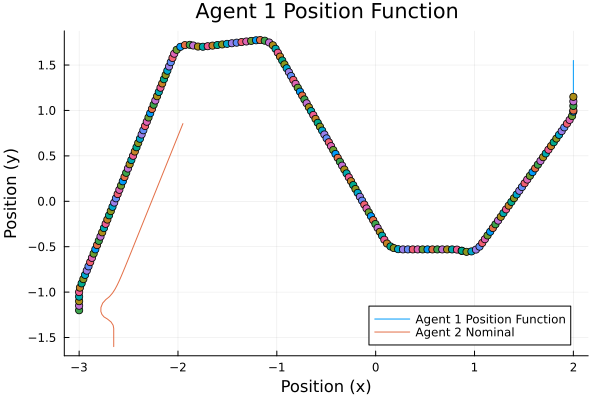

In [88]:

p = plot()
plot!(τ -> pos_func_1(τ)[1], τ -> pos_func_1(τ)[2], 0.0, 10.0, label="Agent 1 Position Function",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

plot!(τ -> agent_2_nominal(τ)[1], τ -> agent_2_nominal(τ)[2], 0.0, 10.0, label="Agent 2 Nominal",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

for site in reconnection_sites
    plot!([site[2][1]], [site[2][2]], seriestype=:scatter, label=false)
end

display(p)

#### Compute Reconnection Paths

In [90]:
connection_paths = GFF.Gatekeeper.construct_reconnection_paths(
    agent_2_gk,
    reconnection_sites,
    agent_2_nominal(switch_2_time)
)

195-element Vector{Any}:
 DubinsManeuver3D{Float64}([-2.0020266026011706, 0.7144599013611564, 0.3838266088812973, 1.2161437268269197, 0.0], [-3.0, -1.2, 0.5, 1.570795, 0.0], 0.15, [-0.7853981633974483, 0.7853981633974483], DubinsManeuver2D[DubinsManeuver2D{Float64}([-2.0020266026011706, 0.7144599013611564, 1.2161437268269197], [-3.0, -1.2, 1.570795], 0.1500225866496105, Dubins3D.DubinsStruct{Float64}(3.274962792128021, 14.054590407379237, 2.6535712418784856, 2.997920018037742, "RSR")), DubinsManeuver2D{Float64}([0.0, 0.3838266088812973, 0.0], [2.997920018037742, 0.5, 0.0], 8.644602445488456, Dubins3D.DubinsStruct{Float64}(0.04441514149577965, 0.25825035235055793, 0.04441514149577965, 3.0003741090601532, "LSR"))], 3.0003741090601483)
 DubinsManeuver3D{Float64}([-2.0020266026011706, 0.7144599013611564, 0.3838266088812973, 1.2161437268269197, 0.0], [-2.99999999999987, -1.15, 0.5, 1.570796326797497, 0.0], 0.15, [-0.7853981633974483, 0.7853981633974483], DubinsManeuver2D[DubinsManeuver2D{Fl

In [91]:
for path in connection_paths
    plot!(τ -> Dubins3D.compute_at_len(path, τ)[1],
          τ -> Dubins3D.compute_at_len(path, τ)[2],
          0.0, path.length,
          label=false,
          xlabel="Position (x)", ylabel="Position (y)",
          title="Reconnection Paths")
end

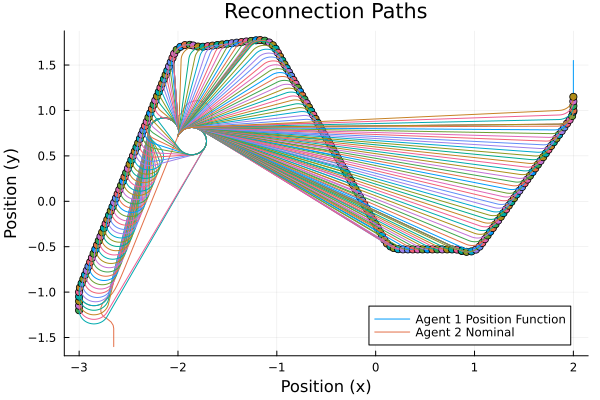

In [92]:
display(p)

In [93]:
shortest_idx = argmin(GFF.Gatekeeper.path_length(agent_2_gk.problem, p) for p in connection_paths)

51

In [94]:
res = is_colliding(
    GFF.Gatekeeper.get_obstacles(agent_2_gk.problem),
    connection_paths[shortest_idx],
    switch_2_time,
    env.gatekeeper_coefficients.collision_check_step_size,
    env.gatekeeper_coefficients.collision_check_step_size * 2.0,
)


false

### Plot the Agents At the Switch Time w/Circles

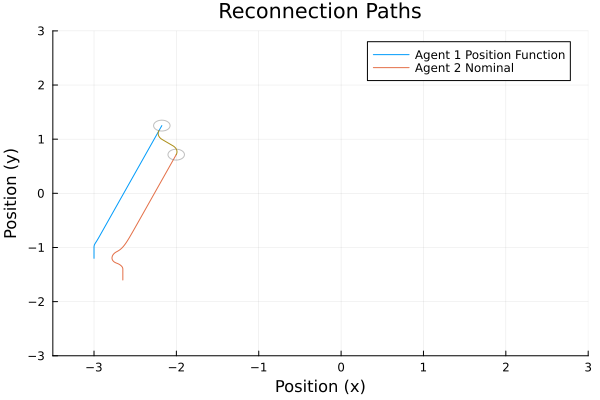

In [95]:
p2 = plot()

plot!(τ -> pos_func_1(τ)[1], τ -> pos_func_1(τ)[2], 0.0, switch_2_time, label="Agent 1 Position Function",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

plot!(τ -> agent_2_nominal(τ)[1], τ -> agent_2_nominal(τ)[2], 0.0, switch_2_time, label="Agent 2 Nominal",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

xlims!(p2, -3.5, 3.0)
ylims!(p2, -3.0, 3.0)

# Plot a parametric circle around agent 1 and agent 2 at the switch time

agent_1_pos = pos_func_1(switch_2_time)[1:2]
agent_2_pos = agent_2_nominal(switch_2_time)[1:2]

r = env.agent_settings.agent_radius
θs = range(0, 2π, length=100)
circle_x = agent_1_pos[1] .+ r .* cos.(θs)
circle_y = agent_1_pos[2] .+ r .* sin.(θs)
plot!(p2, circle_x, circle_y, color=:gray, alpha=0.5, label=false)

r = env.agent_settings.agent_radius
θs = range(0, 2π, length=100)
circle_x = agent_2_pos[1] .+ r .* cos.(θs)
circle_y = agent_2_pos[2] .+ r .* sin.(θs)
plot!(p2, circle_x, circle_y, color=:gray, alpha=0.5, label=false)

# candidate conneciton path
cand_path = connection_paths[shortest_idx]
plot!(p2, τ -> Dubins3D.compute_at_len(cand_path, τ)[1],
     τ -> Dubins3D.compute_at_len(cand_path, τ)[2],
     0.0, cand_path.length,
     label=false,
     xlabel="Position (x)", ylabel="Position (y)",
     title="Reconnection Paths")

In [97]:
path_idx, connection_pt = reconnection_sites[shortest_idx]
remaining_nominal = GFF.Gatekeeper.get_remaining_nominal(
    agent_2_gk.problem,
    path_idx,
    connection_pt
)

6-element Vector{DubinsManeuver3D}:
 DubinsManeuver3D{Float64}([-2.211539982898641, 1.156558590773726, 0.3885427013264305, 1.2161437268858837, -0.04889331460349069], [-1.8456772180364913, 1.7150000000000003, 0.3849999999999992, -0.3313442999059266, 0.2369493431332685], 0.15, [-0.7853981633974483, 0.7853981633974483], DubinsManeuver2D[DubinsManeuver2D{Float64}([-2.211539982898641, 1.156558590773726, 1.2161437268858837], [-1.8456772180364913, 1.7150000000000003, -0.3313442999059266], 0.1527390323167753, Dubins3D.DubinsStruct{Float64}(2.4311692628564696e-5, 3.26068745310337, 1.5475123384844391, 0.7344034966972487, "LSR")), DubinsManeuver2D{Float64}([0.0, 0.3885427013264305, -0.04889331460349069], [0.7344034966972487, 0.3849999999999992, 0.2369493431332685], 0.795625156574921, Dubins3D.DubinsStruct{Float64}(0.00014071531477124544, 0.6402006578057544, 0.28570194242198754, 0.7367833579236711, "LSL"))], 0.7367833579236709)
 DubinsManeuver3D{Float64}([-1.8456772180364913, 1.7150000000000003, 0

#### Plot the Stitched Path

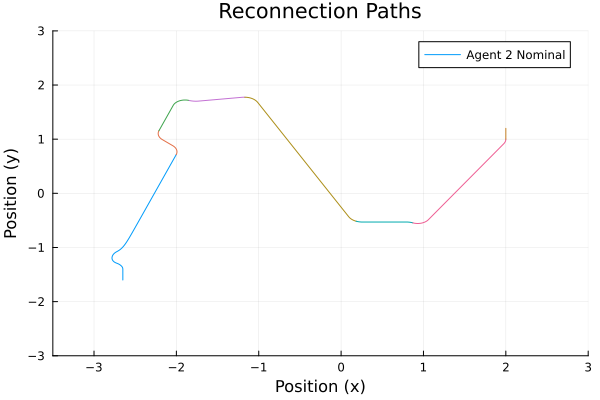

In [99]:
p3 = plot()

plot!(p3, τ -> agent_2_nominal(τ)[1], τ -> agent_2_nominal(τ)[2], 0.0, switch_2_time, label="Agent 2 Nominal",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

xlims!(p3, -3.5, 3.0)
ylims!(p3, -3.0, 3.0)

cand_path = connection_paths[shortest_idx]
plot!(p3, τ -> Dubins3D.compute_at_len(cand_path, τ)[1],
     τ -> Dubins3D.compute_at_len(cand_path, τ)[2],
     0.0, cand_path.length,
     label=false,
     xlabel="Position (x)", ylabel="Position (y)",
     title="Reconnection Paths")

for path in remaining_nominal
     plot!(p3, τ -> Dubins3D.compute_at_len(path, τ)[1],
          τ -> Dubins3D.compute_at_len(path, τ)[2],
          0.0, path.length,
          label=false,
          xlabel="Position (x)", ylabel="Position (y)",
          title="Reconnection Paths")
end
display(p3)

In [130]:
reconnection_time = 0.0 + switch_2_time + cand_path.length

GFF.Gatekeeper.is_colliding_duration(
    GFF.Gatekeeper.get_obstacles(agent_2_gk.problem),
    remaining_nominal,
    reconnection_time,
    mas_check_until_time,
    env.gatekeeper_coefficients.collision_check_step_size,
    env.gatekeeper_coefficients.collision_check_step_size * 2.0    
)

false

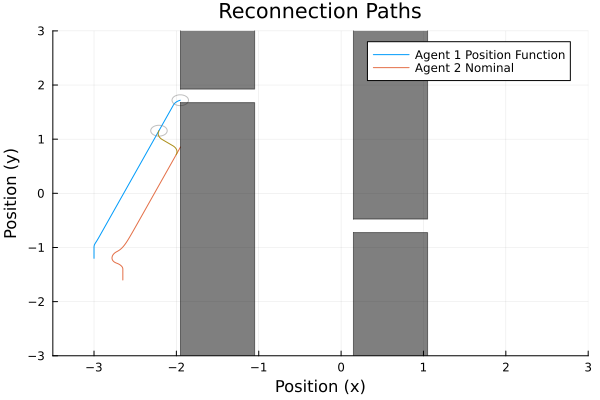

In [125]:
# Plot the agents at the reconnection time
p4 = plot()
plot!(p4, τ -> pos_func_1(τ)[1], τ -> pos_func_1(τ)[2], 0.0, reconnection_time, label="Agent 1 Position Function",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")
plot!(p4, τ -> agent_2_nominal(τ)[1], τ -> agent_2_nominal(τ)[2], 0.0, reconnection_time, label="Agent 2 Nominal",
     xlabel="Position (x)", ylabel="Position (y)", title="Agent 1 Position Function")

xlims!(p4, -3.5, 3.0)
ylims!(p4, -3.0, 3.0)

agent_1_pos = pos_func_1(reconnection_time)[1:2]
agent_2_pos = Dubins3D.compute_at_len(cand_path, cand_path.length)[1:2]

r = env.agent_settings.agent_radius
θs = range(0, 2π, length=100)
circle_x = agent_1_pos[1] .+ r .* cos.(θs)
circle_y = agent_1_pos[2] .+ r .* sin.(θs)
plot!(p4, circle_x, circle_y, color=:gray, alpha=0.5, label=false)

r = env.agent_settings.agent_radius
θs = range(0, 2π, length=100)
circle_x = agent_2_pos[1] .+ r .* cos.(θs)
circle_y = agent_2_pos[2] .+ r .* sin.(θs)
plot!(p4, circle_x, circle_y, color=:gray, alpha=0.5, label=false)

plot!(p4, τ -> Dubins3D.compute_at_len(cand_path, τ)[1],
     τ -> Dubins3D.compute_at_len(cand_path, τ)[2],
     0.0, cand_path.length,
     label=false,
     xlabel="Position (x)", ylabel="Position (y)",
     title="Reconnection Paths")


## Plot the obstacles
for obs in env.obstacles
     plot!(p4, get_2d_repr(obs), label=false)
end

display(p4)

#### Debugging is_colliding_duration

In [117]:
cumulative_times = []
cumulative_times = [0.0; cumsum(p.length for p in remaining_nominal[1:end-1])]
cumulative_times .+= reconnection_time

end_path_idx = findlast(t -> t < reconnection_time + 0.1, cumulative_times)

1

In [128]:
# for obs in agent_2_gk.problem.obstacles
#     @show typeof(obs)
# end

GFF.Obstacles.is_colliding(
    agent_2_gk.problem.obstacles[1], 
    remaining_nominal[1],
    reconnection_time,
    env.gatekeeper_coefficients.collision_check_step_size,
    0.01
)

false